# Masked Image Modeling

Using an autoencoder we try to reconstruct the missing pixels of randomly masked images (i.e. a masked autoencoder with mask size of 75% of image). We use unlabeled images for training the autoencoder. Finally, using the trained encoder of the masked autoencoder we train a model on the labeled images. 

In [ ]:
pip install -U tensorflow-addons

In [ ]:
from tensorflow.keras import layers
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os

In [ ]:
SEED = 1

# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (64, 64, 3)

# OPTIMIZER
LEARNING_RATE = 2e-2
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 11

# AUGMENTATION
IMAGE_SIZE = 64  # We will resize input images to this size.
PATCH_SIZE = 32  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [ ]:
GCS_PATH = 'gs://kds-57f9ca82c6ece747fdb97da243e70f5c8414ca9cf66a8576e6c00740'
VERBOSE = 1
train = pd.read_csv('train.csv')
NUM_CLASSES = train.species.nunique()
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/train/*.png')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/test/*.png')
STEPS_PER_EPOCH = len(TRAINING_FILENAMES)+len(TEST_FILENAMES) // BATCH_SIZE

NFOLD = 5
VAL_FOLD = 0
TEST_FOLD = 1

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(SEED)

In [ ]:
from IPython.display import clear_output

tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

clear_output()    

# Dataset

In [ ]:
train = pd.read_csv('train.csv')

encoder = LabelEncoder()
train['labels'] = encoder.fit_transform(train.species)

gkf  = GroupKFold(n_splits = NFOLD)
train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train, groups = train.individual_id.tolist())):
    train.loc[val_idx, 'fold'] = fold

train.head(1)


,image,species,individual_id,labels,fold
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,18,2


In [ ]:
valid_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[train['fold'] == VAL_FOLD]['image'].str.split('.').values]
test_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[train['fold'] == TEST_FOLD]['image'].str.split('.').values]
train_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[(train['fold'] != VAL_FOLD) & (train['fold'] != TEST_FOLD)]['image'].str.split('.').values]

valid_labels = np.array(train[train['fold'] == VAL_FOLD]['labels']).reshape(-1,1)
test_labels = np.array(train[train['fold'] == TEST_FOLD]['labels']).reshape(-1,1)
train_labels = np.array(train[(train['fold'] != VAL_FOLD) & (train['fold'] != TEST_FOLD)]['labels']).reshape(-1,1)

def decode_img(path):
    file_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(file_bytes, channels=3)
    return img

def load_dataset(filename):
    img = decode_img(filename)
    return img

train_ds = tf.data.Dataset.from_tensor_slices(train_paths)

train_ds = train_ds.map(load_dataset, num_parallel_calls = AUTO).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(AUTO)

valid_ds = tf.data.Dataset.from_tensor_slices(valid_paths)

valid_ds = valid_ds.map(load_dataset, num_parallel_calls = AUTO).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(TEST_FILENAMES)

test_ds = test_ds.map(load_dataset, num_parallel_calls = AUTO).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

# Augmentation pipeline 

- Resizing
- Random cropping (fixed-sized or random sized)
- Random horizontal flipping

In [ ]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0), 
            layers.Resizing(IMAGE_SIZE + 20, IMAGE_SIZE + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [
         layers.Rescaling(1 / 255.0), 
         layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

#  Extracting patches from images

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed


Index selected: 37.


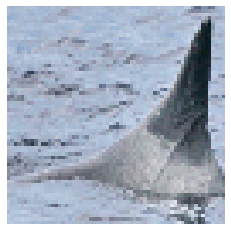

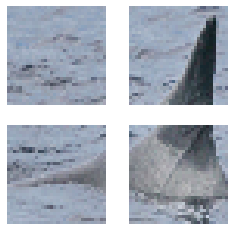

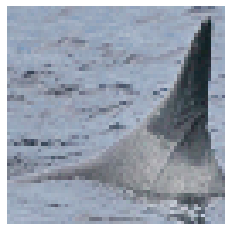

In [ ]:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

# Patch encoding with masking

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx


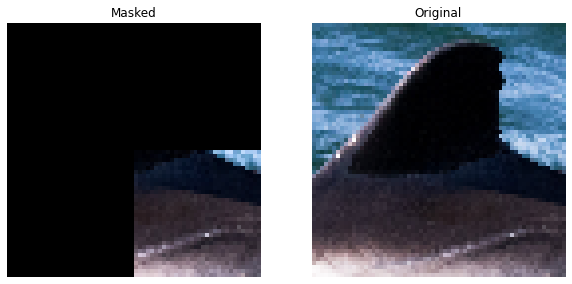

In [ ]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

# Fully connected feed forward network

In [ ]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Vision Transformer as Masked Autoencoder

In [ ]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")


#  A lightweight decoder

In [ ]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


# MAE Trainer

In [ ]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}


In [ ]:
# # Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_ds))

class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

In [ ]:
total_steps = int((len(train_paths) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
learning_rate_base=LEARNING_RATE,
total_steps=total_steps,
warmup_learning_rate=0.0,
warmup_steps=warmup_steps,
)
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

In [ ]:
with strategy.scope():
  tf.config.set_soft_device_placement(True)
  train_augmentation_model = get_train_augmentation_model()
  test_augmentation_model = get_test_augmentation_model()
  patch_layer = Patches()
  patch_encoder = PatchEncoder()
  encoder = create_encoder()
  decoder = create_decoder()

  total_steps = int((len(train_paths) / BATCH_SIZE) * EPOCHS)
  warmup_epoch_percentage = 0.15
  warmup_steps = int(total_steps * warmup_epoch_percentage)
  scheduled_lrs = WarmUpCosine(
  learning_rate_base=LEARNING_RATE,
  total_steps=total_steps,
  warmup_learning_rate=0.0,
  warmup_steps=warmup_steps,
  )
  optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

  mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
    )
  
  # Compile and pretrain the model.
  mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
    )

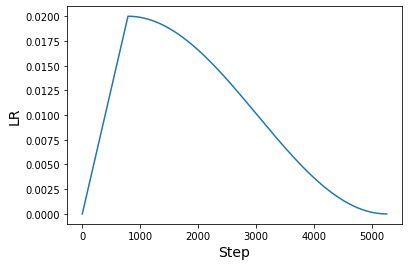

In [ ]:
lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

Epoch 1/11
478/478 [==============================] - ETA: 0s - loss: 0.0375 - mae: 0.1537
Idx chosen: 12


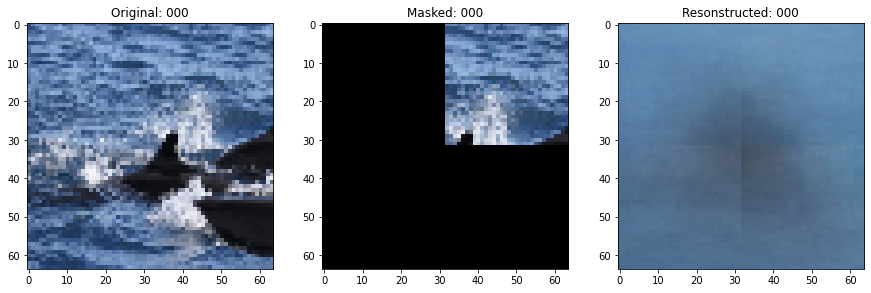

478/478 [==============================] - 941s 2s/step - loss: 0.0375 - mae: 0.1537
Epoch 2/11
478/478 [==============================] - 96s 201ms/step - loss: 0.0310 - mae: 0.1360
Epoch 3/11
478/478 [==============================] - 116s 243ms/step - loss: 0.0286 - mae: 0.1291
Epoch 4/11
478/478 [==============================] - 94s 198ms/step - loss: 0.0281 - mae: 0.1272
Epoch 5/11
478/478 [==============================] - 95s 198ms/step - loss: 0.0276 - mae: 0.1257
Epoch 6/11
478/478 [==============================] - ETA: 0s - loss: 0.0270 - mae: 0.1238
Idx chosen: 8


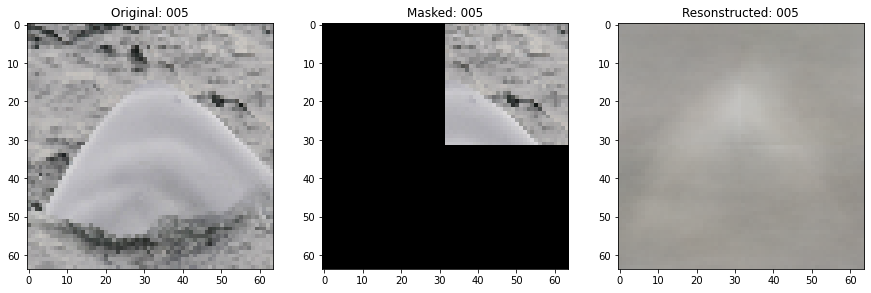

478/478 [==============================] - 96s 201ms/step - loss: 0.0270 - mae: 0.1238
Epoch 7/11
478/478 [==============================] - 96s 200ms/step - loss: 0.0264 - mae: 0.1221
Epoch 8/11
478/478 [==============================] - 102s 214ms/step - loss: 0.0261 - mae: 0.1212
Epoch 9/11
478/478 [==============================] - 96s 200ms/step - loss: 0.0256 - mae: 0.1194
Epoch 10/11
478/478 [==============================] - 479s 1s/step - loss: 0.0251 - mae: 0.1181 - val_loss: 0.0273 - val_mae: 0.1241
Epoch 11/11
478/478 [==============================] - ETA: 0s - loss: 0.0249 - mae: 0.1175
Idx chosen: 63


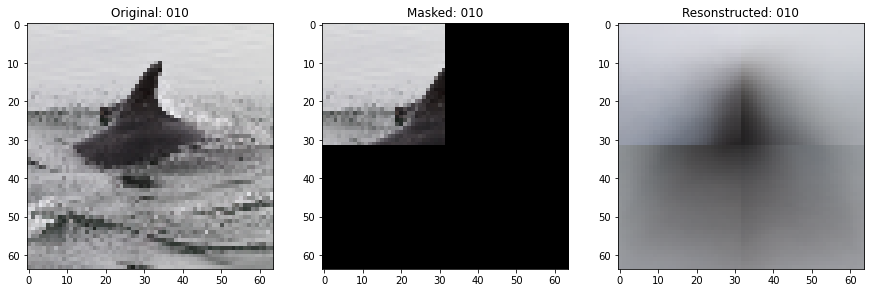

478/478 [==============================] - 95s 200ms/step - loss: 0.0249 - mae: 0.1175


In [ ]:
# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=train_callbacks, validation_freq=10
)

In [ ]:
# Measure its performance.
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

437/437 [==============================] - 1131s 2s/step - loss: 0.0272 - mae: 0.1239
Loss: 0.03
MAE: 0.12


# Extract the encoder model along with other layers

In [ ]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
with strategy.scope():

  downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
    )

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
  layer.trainable = False

  optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
  downstream_model.compile(
  optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
      )

downstream_model.summary()

Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches_1 (Patches)         (None, 4, 3072)           0         
                                                                 
 patch_encoder_1 (PatchEncod  (None, 4, 128)           396928    
 er)                                                             
                                                                 
 mae_encoder (Functional)    (None, None, 128)         1981696   
                                                                 
 batch_normalization (BatchN  (None, 4, 128)           512       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                

In [ ]:
def load_dataset(filename, labels):
    img = decode_img(filename)
    return img, labels

def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels)).map(load_dataset, num_parallel_calls = AUTO).cache()

    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)

del train_ds, valid_ds
import gc
gc.collect()    

train_ds = prepare_data(train_paths, train_labels)
val_ds = prepare_data(valid_paths, valid_labels, is_train=False)

# Evaluation with linear probing

In [ ]:
linear_probe_epochs = 11
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(TRAINING_FILENAMES) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

Epoch 1/11
479/479 [==============================] - 1246s 3s/step - loss: 2.3937 - accuracy: 0.3284 - val_loss: 2.1535 - val_accuracy: 0.3652
Epoch 2/11
479/479 [==============================] - 53s 111ms/step - loss: 1.9757 - accuracy: 0.4171 - val_loss: 1.9979 - val_accuracy: 0.4053
Epoch 3/11
479/479 [==============================] - 56s 115ms/step - loss: 1.9047 - accuracy: 0.4303 - val_loss: 1.9974 - val_accuracy: 0.3995
Epoch 4/11
479/479 [==============================] - 54s 113ms/step - loss: 1.8773 - accuracy: 0.4353 - val_loss: 1.9983 - val_accuracy: 0.3990
Epoch 5/11
479/479 [==============================] - 54s 113ms/step - loss: 1.8586 - accuracy: 0.4418 - val_loss: 1.9490 - val_accuracy: 0.4139
Epoch 6/11
479/479 [==============================] - 54s 114ms/step - loss: 1.8402 - accuracy: 0.4423 - val_loss: 1.9581 - val_accuracy: 0.4138
Epoch 7/11
479/479 [==============================] - 54s 113ms/step - loss: 1.8282 - accuracy: 0.4452 - val_loss: 1.9448 - val_acc

In [ ]:
test_ds = prepare_data(test_paths, test_labels, is_train=False)
loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

160/160 [==============================] - 398s 2s/step - loss: 1.8074 - accuracy: 0.4569
Accuracy on the test set: 45.69%.


#### Just after few epochs the MAE starts to reconstruct the images and allows linear probing to work. Improved results can be achieved with higher number of epochs.